# NIH data CNN notebook

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import streamlit as st
from keras import layers
from keras import models
import matplotlib.pyplot as plt
import struct
from array import array
from os.path  import join
import csv

## Train/test split

This code creates the training and test data sets. It ingests images from the 'images' directory, and copies them into one of the new directories, it then creates a version of the labels csv in each directory

In [2]:
import CNN.preprocess as pp

In [3]:
train_set, test_set = pp.train_test_split_images(join("data"), 0.8)
pp.train_test_split_labels(join("data"), train_set, test_set)

Created test and training directories
train_set: 4484 elements
test_set: 1122 elements


# Emphysema detector Network
Let's try a network to detect emphysema cxr's first, baby steps.

We'll make a copy of the `test_nih` and `training_nih` labels file and remove all the other conditions from the `labels.csv`

In [4]:
pp.filter_emphysema_rows(join('data', 'sample_labels.csv'), join('data', 'emph_labels.csv'))
pp.filter_emphysema_rows(join('data', 'test_nih', 'labels.csv'), join('data', 'test_nih', 'emph_labels.csv'))
pp.filter_emphysema_rows(join('data', 'training_nih', 'labels.csv'), join('data', 'training_nih', 'emph_labels.csv'))

## Summarise the test and training directories

In [5]:
import os

def count_images(directory_name: str) -> int:
    """
    Count the number of images in a directory.

    Args:
        directory_name (str): Name of the directory to count images in.

    Returns:
        int: The number of images in the directory.
    """
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif']  # Add more extensions if needed

    # Initialize the counter
    count = 0

    # Iterate over files in the directory
    for filename in os.listdir(directory_name):
        # Check if the file has an image extension
        if any(filename.lower().endswith(ext) for ext in image_extensions):
            count += 1

    print(f"Number of images in {directory_name}: {count}")
    return count

import csv

def count_csv_rows(file_name: str) -> int:
    """
    Count the number of rows in a CSV file.

    Args:
        file_name (str): Name of the CSV file.

    Returns:
        int: The number of rows in the CSV file.
    """
    # Initialize the row count
    count = 0

    # Open the CSV file and iterate over its rows
    with open(file_name, 'r') as file:
        csv_reader = csv.reader(file)
        for row in csv_reader:
            count += 1

    print(f"Number of rows in {file_name}: {count}")
    return count



In [6]:
count_images(join('data','training_nih','images'))
count_images(join('data','test_nih','images'))
count_csv_rows(join('data','training_nih','emph_labels.csv'))
count_csv_rows(join('data','test_nih','emph_labels.csv'))

Number of images in data\training_nih\images: 4484
Number of images in data\test_nih\images: 1122
Number of rows in data\training_nih\emph_labels.csv: 4484
Number of rows in data\test_nih\emph_labels.csv: 1122


1122

## Building CNN model
Helper functions to manage model building, training and training analysis

In [7]:
from keras.optimizers import RMSprop
from sklearn.metrics import precision_score, recall_score, f1_score


def compile_model(learning_rate: float):
    # Setting up the convolution neural network with convnet and maxpooling layer
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(512, 512, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))

    # Model Summary
    print(f'model.summary(): {model.summary()}')

    # Adding the fully connected layers to CNN
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(2, activation='softmax'))

    # Printing model summary
    print(f'model.summary(): {model.summary()}')

    # Create the optimizer with a new learning rate
    optimizer = RMSprop(learning_rate=learning_rate)

    # Configuring the network with the custom optimizer
    model.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])
    # # Configuring the network
    # model.compile(optimizer='rmsprop(lr=0.0025)',
    #             loss='binary_crossentropy',
    #             metrics=['accuracy'])
    
    return model


def train_model(X_train, Y_train, X_test, Y_test, model, epochs, batch_size):
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size)

    # Predict on test set
    y_pred = model.predict(X_test)
    y_pred = (y_pred > 0.5).astype(int)

    # Calculate precision, recall, and F1 score
    precision = precision_score(Y_test, y_pred)
    recall = recall_score(Y_test, y_pred)
    f1 = f1_score(Y_test, y_pred)

    return history, precision, recall, f1


## Data Augmentation
We're getting serious overfitting in the previous notebooks model, lets take the minority category  in the training dataset and apply rotations, and mirroring. We'll exclude scaling and cropping for now since the images are all pretty tight on the torso.

Here's the data ingestion methods which will be used to ingest the images as python objects

In [8]:
import os
import glob
from PIL import Image
import numpy as np
from array import array
import random
from IPython.display import clear_output
clear_output(wait=True)


# MNIST Data Loader Class
class NIHDataloader(object):
    def __init__(self, 
                training_images_filepath,
                training_labels_filepath,
                test_images_filepath, 
                test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    

    def read_labels(self, labels_filepath: str, label_only: bool = True):        
        labels = []
        
        with open(labels_filepath, 'r') as file:
            reader = csv.reader(file)
            if label_only:
                labels = array("B", [1 if row[1]=="true" else 0 for row in reader])   
            else:
                # print([row for row in reader if row[1] == "true"])
                labels = [row for row in reader]
            
        return labels

    def read_images(self, images_filepath):        
        images = []
                        
        # Get the list of image file paths in the directory
        image_paths = glob.glob(os.path.join(images_filepath, "*.png"))

        # Iterate over each image path
        for image_path in image_paths:
            image = Image.open(image_path)
            resized_image = image.resize((512, 512))
            grayscale_image = resized_image.convert("L")
            # array = np.array(grayscale_image).astype(float)
            array = np.array(grayscale_image).astype(np.float16)

            images.append(array)

        return images
        
            
    def load_data(self):
        x_train = self.read_images(self.training_images_filepath)
        y_train = self.read_labels(self.training_labels_filepath)
        x_test = self.read_images(self.training_images_filepath)
        y_test = self.read_labels(self.training_labels_filepath)

          # Convert data to NumPy arrays
        x_train = np.array(x_train)
        y_train = np.array(y_train)
        x_test = np.array(x_test)
        y_test = np.array(y_test)
        
        return (x_train, y_train),(x_test, y_test)    


The following class contains methods used for generating, and applying transformations, and saving the resultant images to disk. 

In [9]:
import shutil


class Transform:
    def __init__(self, 
                training_images_filepath,
                training_labels_filepath,
                test_images_filepath, 
                test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
        

    def augmented_training_images(self):
        """
        Function to augment minority category of training data to be of equal size to majority category

        Steps: 
            - ingest training images and labels from new data subdir
            for each image in training set (while len(cat A)<len(cat B))
            - create new unique id
            - write row to label csv
            - apply one of a set of transformations to the new image and save it in image subdir
        """
        image_paths = glob.glob(
            join(self.training_images_filepath, "*.png")
            )
        nih_dataloader = NIHDataloader(self.training_images_filepath, self.training_labels_filepath, self.test_images_filepath, self.test_labels_filepath)
        y_train = nih_dataloader.read_labels(self.training_labels_filepath, label_only = False)
    
        minority_cat = [el for el in y_train if el[1] == "true"]
        majority_cat = [el for el in y_train if el[1] == "false"]

        print(f'minority_cat: {len(minority_cat)}')
        print(f'majority_cat: {len(majority_cat)}')
        
        theta = -15
        for image_path in image_paths:
            
            print(f'image in set: {image_path}')

            # stop once we reach a balanced dataset
            if len(minority_cat) > len(majority_cat):
                break

            # apply a random transformation to the majority cat images
            if any(image_path.split('\\')[-1] in sublist for sublist in majority_cat):
                theta, transpose = 0, 0
                while theta == 0 and transpose == 0:
                    theta = random.randint(0, 23) * 15
                    transpose = random.randint(0,1)
                
                # update image
                self.apply_transform(theta, transpose, image_path, 'MAX')
                
                # update labels
                self.update_image_id(self.training_labels_filepath
                    ,image_path.split(os.path.sep)[-1]
                    ,theta
                    ,transpose
                    ,'MAX'
                )
                # break
                if os.path.exists(image_path):
                    os.remove(image_path)
                else:
                    print("File does not exist.")
                    

            # apply 48 unique transformations to each image in the minority category
            if any(image_path.split('\\')[-1] in sublist for sublist in minority_cat):
                theta = 0
                for i in range(48):
                    transpose, theta = self.return_transform(i, theta)
                    self.apply_transform(theta, transpose, image_path, 'MIN')

                    self.update_image_id(self.training_labels_filepath
                        ,image_path.split(os.path.sep)[-1]
                        ,theta
                        ,transpose
                        ,'MIN'
                    )
                    # break
                        
                if os.path.exists(image_path):
                    os.remove(image_path)
                else:
                    print("File does not exist.")
        
        # remove original labels from the csv
        self.cleanup_labels(16)


    def cleanup_labels(self, n: int):
        # Create a temporary file to write the filtered rows
        temp_file = self.training_labels_filepath + '.temp'
        
        # Open the original CSV file for reading
        with open(self.training_labels_filepath, 'r') as file, open(temp_file, 'w', newline='') as temp:
            reader = csv.DictReader(file)
            writer = csv.DictWriter(temp, fieldnames=reader.fieldnames)
                
            # Iterate through each row
            for row in reader:
                if len(row['image_id']) > n:
                    writer.writerow(row)

        # Replace the original file with the temporary file
        shutil.move(temp_file, self.training_labels_filepath)


                    

    def save_image(self, image: Image.Image, og_path: str, theta: int, mirr: bool, cat: str):
        new_path = og_path.split('.')[0] + f'_R{theta}_T{int(mirr)}_{cat}.' + og_path.split('.')[1]
        # print(f'new path: {new_path}')
        image.save(new_path)


    def update_image_id(self, csv_file: str, image_id: str, theta: int, mirr: bool, cat: str):
        """
        Function to update image label in csv
            - read existing row from csv file to python
            - generate a new unique id of form "<original_id>_R<rotation>_T<translation>" and write back to csv
        """
        
        root_id = '_'.join(image_id.split('_')[0:2])
        
        # Read the CSV file
        with open(csv_file, 'r') as file:
            reader = csv.DictReader(file)
            rows = list(reader)

        # Find the row with the given image_id and update the image_id value
        for row in rows:
            if row['image_id'] == root_id:
                new_id = image_id.split('.')[0] + f'_R{theta}_T{int(mirr)}_{cat}' + '.png'
                new_row = row.copy()
                new_row['image_id'] = new_id
                rows.append(new_row)
                break

        # Write the updated rows back to the CSV file
        with open(csv_file, 'w', newline='') as file:
            writer = csv.DictWriter(file, fieldnames=reader.fieldnames)
            writer.writeheader()
            writer.writerows(rows)


    def apply_transform(self, theta, transpose, image_path, cat: str):
        
        # print(f'Transformation: (θ,T): {(theta, transpose)}')
        image = Image.open(image_path)
        image = self.transpose(image) if transpose == 1 else image
        image = self.rotate(image, theta)
        
        self.save_image(image, image_path, theta, transpose, cat)


    def return_transform(self, iter, theta):
        transform = iter%2
        if iter%2 == 0:
            theta += 15
        theta %= 360

        return transform, theta
    
    
    def transpose(self, image):
        image = image.transpose(Image.FLIP_LEFT_RIGHT)
        return image
    

    def rotate(self, image, theta):
        image = image.rotate(theta)
        return image
        

Ingest data and map labels to categorical data format

In [56]:

clear_output(wait=True)

# Set file paths based on added MNIST Datasets``
input_path = 'data'
training_images_filepath = join(input_path, join('training_nih', 'images'))
training_labels_filepath = join(input_path, join('training_nih', 'emph_labels.csv'))
test_images_filepath = join(input_path, join('test_nih', 'images'))
test_labels_filepath = join(input_path, join('test_nih', 'emph_labels.csv'))

# Load MINST dataset
transform = Transform(training_images_filepath,
    training_labels_filepath,
    test_images_filepath,
    test_labels_filepath
    )

# testing labels update
transform.update_image_id(join(input_path, join('training_nih', 'emph_labels.csv'))
    ,'00000370_003.png'
    ,1
    ,0
    ,'test'
)

testing update label fn
csv file: data\training_nih\emph_labels.csv
image_id: 00000370_003.png
root_id: 00000370_003.png
new row: {'image_id': '00000370_003.png', 'emphysema': 'false', '005': '003', '00000013': '00000370', '060Y': '055Y', 'M': 'F', 'AP': 'PA', '3056': '2048', '2544': '2500', '0.139': '0.171'}
new_id: 00000370_003_R1_T0_test.png


In [10]:

clear_output(wait=True)

# Set file paths based on added MNIST Datasets``
input_path = 'data'
training_images_filepath = join(input_path, join('training_nih', 'images'))
training_labels_filepath = join(input_path, join('training_nih', 'emph_labels.csv'))
test_images_filepath = join(input_path, join('test_nih', 'images'))
test_labels_filepath = join(input_path, join('test_nih', 'emph_labels.csv'))

# Load MINST dataset
transform = Transform(training_images_filepath,
    training_labels_filepath,
    test_images_filepath,
    test_labels_filepath
    )

# join('data','training_nih', 'images'), join('data','training_nih'))
transform.augmented_training_images()

minority_cat: 94
majority_cat: 4389
image in set: data\training_nih\images\00000013_005.png
image in set: data\training_nih\images\00000013_026.png
image in set: data\training_nih\images\00000017_001.png
image in set: data\training_nih\images\00000030_001.png
image in set: data\training_nih\images\00000032_001.png
image in set: data\training_nih\images\00000040_003.png
image in set: data\training_nih\images\00000042_002.png
image in set: data\training_nih\images\00000057_001.png
image in set: data\training_nih\images\00000061_002.png
image in set: data\training_nih\images\00000061_019.png
image in set: data\training_nih\images\00000061_025.png
image in set: data\training_nih\images\00000079_000.png
image in set: data\training_nih\images\00000080_005.png
image in set: data\training_nih\images\00000083_000.png
image in set: data\training_nih\images\00000084_000.png
image in set: data\training_nih\images\00000096_006.png
image in set: data\training_nih\images\00000099_003.png
image in set

Check that the majority/minority categories are balanced

In [11]:
count_images(join('data','training_nih','images'))
count_images(join('data','test_nih','images'))
count_csv_rows(join('data','training_nih','emph_labels.csv'))
count_csv_rows(join('data','test_nih','emph_labels.csv'))

Number of images in data\training_nih\images: 8902
Number of images in data\test_nih\images: 1122
Number of rows in data\training_nih\emph_labels.csv: 8901
Number of rows in data\test_nih\emph_labels.csv: 1122


1122

In [4]:
from IPython.display import clear_output
clear_output(wait=True)

def return_transform(iter, theta):
    transform = []
    if iter%2 == 1:
        transform.append("mirror()")
    if iter%2 == 0:
        theta += 15
    theta %= 360
    transform.append(f"rotate({theta})")

    return transform, theta

theta = -15
for i in range(48):
    transform, theta = return_transform(i, theta)
    print(transform)

['rotate(0)']
['mirror()', 'rotate(0)']
['rotate(15)']
['mirror()', 'rotate(15)']
['rotate(30)']
['mirror()', 'rotate(30)']
['rotate(45)']
['mirror()', 'rotate(45)']
['rotate(60)']
['mirror()', 'rotate(60)']
['rotate(75)']
['mirror()', 'rotate(75)']
['rotate(90)']
['mirror()', 'rotate(90)']
['rotate(105)']
['mirror()', 'rotate(105)']
['rotate(120)']
['mirror()', 'rotate(120)']
['rotate(135)']
['mirror()', 'rotate(135)']
['rotate(150)']
['mirror()', 'rotate(150)']
['rotate(165)']
['mirror()', 'rotate(165)']
['rotate(180)']
['mirror()', 'rotate(180)']
['rotate(195)']
['mirror()', 'rotate(195)']
['rotate(210)']
['mirror()', 'rotate(210)']
['rotate(225)']
['mirror()', 'rotate(225)']
['rotate(240)']
['mirror()', 'rotate(240)']
['rotate(255)']
['mirror()', 'rotate(255)']
['rotate(270)']
['mirror()', 'rotate(270)']
['rotate(285)']
['mirror()', 'rotate(285)']
['rotate(300)']
['mirror()', 'rotate(300)']
['rotate(315)']
['mirror()', 'rotate(315)']
['rotate(330)']
['mirror()', 'rotate(330)']
['ro

## Rotate and translate functions

data\training_nih\images\00000013_005.png
image_path: data\training_nih\images\00000013_005.png
new_path: data\training_nih\images\00000013_005.png_R45_mirr


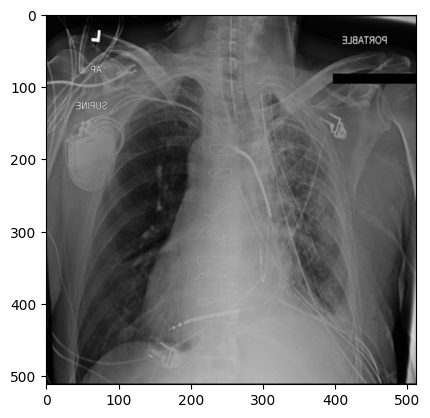

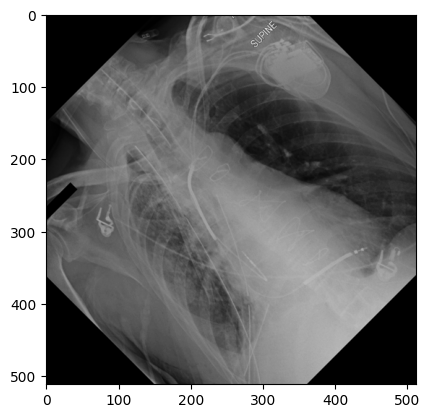

In [23]:
import matplotlib.pyplot as plt

# Get the list of image file paths in the directory
image_paths = glob.glob(os.path.join('data', 'training_nih', 'images', "*.png"))

class Transform:
    def __init__(self):
        self.image_paths = glob.glob(os.path.join('data', 'training_nih', 'images', "*.png"))
    
    def transpose(self, image):
        image = image.transpose(Image.FLIP_LEFT_RIGHT)
        return image

    def rotate(self, image, theta):
        image = image.rotate(theta)
        return image
        

# Create an instance of the Transform class
transform = Transform()

# Iterate over each image path
for image_path in image_paths:
    print(image_path)
    # image = Image.open(image_path).rotate(45)
    image = Image.open(image_path)
    
    theta = 45
    mirr = True
    if mirr:
        image_mirror = transform.transpose(image)
    image_rotate = transform.rotate(image, theta)
    
    print(f'image_path: {image_path}')
    new_path = image_path + f'_R{theta}_mirr' if mirr else image_path + f'_R{theta}_mirr'
    print(f'new_path: {new_path}')

    resized_image = image_mirror.resize((512, 512))
    grayscale_image = resized_image.convert("L")
    array = np.array(grayscale_image).astype(np.float16)

    # Plot the image using imshow
    plt.imshow(array, cmap='gray')
    plt.show()

    resized_image = image_rotate.resize((512, 512))
    grayscale_image = resized_image.convert("L")
    array = np.array(grayscale_image).astype(np.float16)

    # Plot the image using imshow
    plt.imshow(array, cmap='gray')
    plt.show()

    # image_mirror.save(join(image_path, ''))
    
    break


Ingest data and map labels to categorical data format

In [ ]:
import os
import glob
from PIL import Image
import numpy as np
from array import array


# MNIST Data Loader Class
class NIHDataloader(object):
    def __init__(self, 
                training_images_filepath,
                training_labels_filepath,
                test_images_filepath, 
                test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    

    def read_labels(self, labels_filepath):        
        labels = []
        images = []
        
        with open(labels_filepath, 'r') as file:
            reader = csv.reader(file)
            labels = array("B", [1 if row[1]=="true" else 0 for row in reader])   
        
        return labels

    def read_images(self, images_filepath):        
        labels = []
        images = []
                        
        # Get the list of image file paths in the directory
        image_paths = glob.glob(os.path.join(images_filepath, "*.png"))

        # Iterate over each image path
        for image_path in image_paths:
            image = Image.open(image_path)
            resized_image = image.resize((512, 512))
            grayscale_image = resized_image.convert("L")
            # array = np.array(grayscale_image).astype(float)
            array = np.array(grayscale_image).astype(np.float16)

            images.append(array)

        return images
        
    def augmented_training_images(self, training_filepath: str):
        """
        Function to augment minority category of training data to be of equal size to majority category

        Steps: 
            - ingest training images and labels from new data subdir
            for each image in training set (while len(cat A)<len(cat B))
            - create new unique id
            - write row to label csv
            - apply one of a set of transformations to the new image and save it in image subdir
        """
        # x_train = self.read_images(join(training_filepath, "images"))
        # y_train = self.read_labels(training_filepath)
        # x_train = self.read_images(self.training_images_filepath)
        y_train = self.read_labels(self.training_labels_filepath)
    
        # print(f'x_train: {len(x_train)}')
        print(f'y_train: {len(y_train)}')

        # minority_cat = y_train[y_train[1] == "true"]
        minority_cat = [el for el in y_train if el == 1]
        # majority_cat = y_train[y_train[1] == "false"]
        majority_cat = [el for el in y_train if el == 0]


        print(f'minority_cat: {len(minority_cat)}')
        print(f'majority_cat: {len(majority_cat)}')
        print(f'Need to make {len(majority_cat)/len(minority_cat)} duplicates of each minority case')

        theta = -15
        for image in training_set:
            if len(minority_cat) < len(majority_cat):
                break

            for i in range(48):
                transform, theta = self.return_transform(iter, theta)
                # Iterate over each item in the array
                for call in transform:
                    try:
                        # Execute the function call using exec()
                        _image = exec(call, image)
                    except Exception as e:
                        print('Error executing function:', e)

            # 

    def return_transform(iter, theta):
        transform = []
        if iter%2 == 1:
            transform.append("mirror()")
        if iter%2 == 0:
            theta += 15
        theta %= 360
        transform.append(f"rotate({theta})")

        return transform, theta

    def return_transform(iter, theta):
        transform = []
        if iter%2 == 1:
            transform.append("mirror()")
        theta += 15
        theta %= 360
        transform.append(f"rotate({theta})")

        return transform, theta

            
    def load_data(self):
        x_train = self.read_images(self.training_images_filepath)
        y_train = self.read_labels(self.training_labels_filepath)
        x_test = self.read_images(self.training_images_filepath)
        y_test = self.read_labels(self.training_labels_filepath)

          # Convert data to NumPy arrays
        x_train = np.array(x_train)
        y_train = np.array(y_train)
        x_test = np.array(x_test)
        y_test = np.array(y_test)
        
        return (x_train, y_train),(x_test, y_test)        

In [27]:
(x_train, y_train), (x_test, y_test) = nih_dataloader.load_data()
print('loaded data')

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print('mapped y data to categorical')

loaded data
mapped y data to categorical


In [28]:
print(f'x_train: {x_train[0]}')
print(f'y_train: {y_train[0]}')
print(f'x_test: {x_test[0]}')
print(f'y_test: {y_test[0]}')

x_train: [[ 85.  85.  84. ...   5.   5.   5.]
 [ 84.  84.  83. ...   5.   5.   5.]
 [ 80.  79.  79. ...   5.   5.   5.]
 ...
 [120. 122. 131. ...   7.   2.   2.]
 [115. 119. 129. ...   5.   3.   4.]
 [ 40.  41.  43. ...   3.   3.   3.]]
y_train: [1. 0.]
x_test: [[ 85.  85.  84. ...   5.   5.   5.]
 [ 84.  84.  83. ...   5.   5.   5.]
 [ 80.  79.  79. ...   5.   5.   5.]
 ...
 [120. 122. 131. ...   7.   2.   2.]
 [115. 119. 129. ...   5.   3.   4.]
 [ 40.  41.  43. ...   3.   3.   3.]]
y_test: [1. 0.]


In [46]:
model = compile_model(0.005)
print('compiled model')

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 510, 510, 32)      320       
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 255, 255, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 253, 253, 64)      18496     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 126, 126, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 124, 124, 64)      36928     
                                                                 
Total params: 55744 (217.75 KB)
Trainable params: 5574

In [56]:
history, precision, recall, f1 = train_model(x_train, y_train, x_test, y_test, model, 32, 32)
print('train model')

Epoch 1/32
  2/141 [..............................] - ETA: 12:37 - loss: 0.0818 - accuracy: 0.9844

KeyboardInterrupt: 

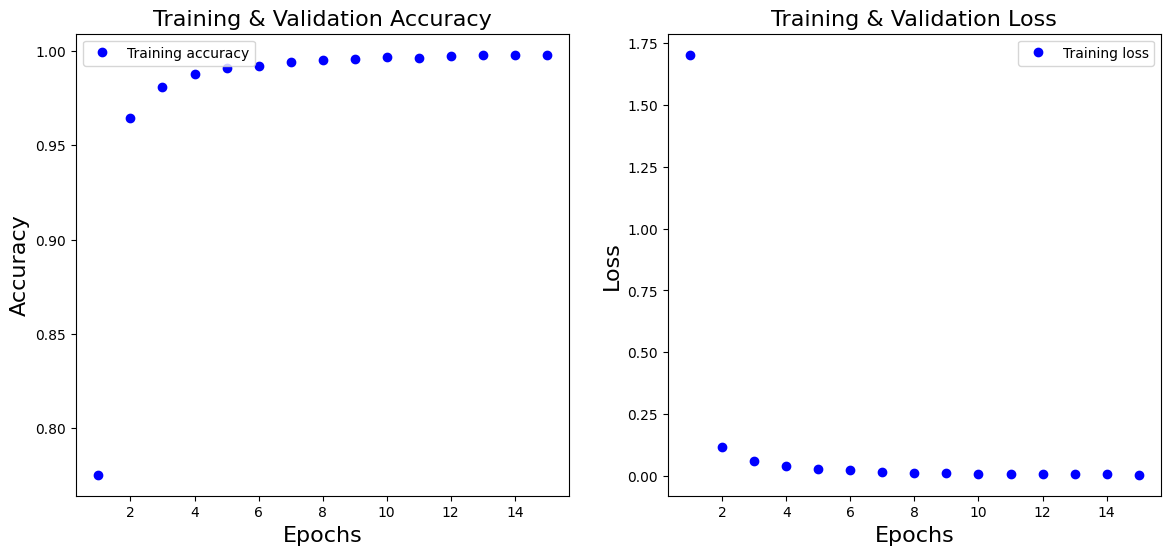

313/313 [==============================] - 3s 9ms/step - loss: 0.0578 - accuracy: 0.9906


2023-09-01 14:47:06.280 
  command:

    streamlit run C:\Users\ShaneShort\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py [ARGUMENTS]


analyse training


In [6]:
test_loss, test_acc = analyse_history(model, history, x_test, y_test)
print('analyse training')

Testing model against individual images

1/1 [==============================] - 0s 207ms/step
Prediction: 8
True Label: 8


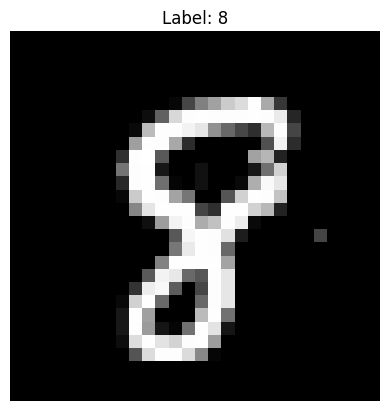

In [7]:
import matplotlib.pyplot as plt
import random

def _test_single(X_test, Y_test, image_index):
    image = X_test[image_index]  # Get the corresponding image data from X_test
    label = Y_test[image_index]  # Get the corresponding label data from y_test

    image = image.reshape(28, 28)  # Reshape the image array from (28, 28, 1) to (28, 28)

    plt.imshow(image, cmap='gray')  # Display the image using grayscale color map
    plt.title(f"Label: {np.argmax(label)}")  # Set the title of the plot with the true label
    plt.axis('off')  # Remove the axis labels

    return plt.gcf()  # Return the current figure for later plotting

image_index = random.randint(0, len(x_test)-1)  # Generate a random index within the range of the test set
label = y_test[image_index]  # Get the corresponding label data from y_test
prediction = model.predict(np.expand_dims(x_test[image_index], axis=0))
predicted_label = np.argmax(prediction)

print("Prediction:", predicted_label)
print("True Label:", np.argmax(label))

figure = _test_single(x_test, y_test, image_index)
plt.show()  # Show the plot
